In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import jax
import jax.numpy as jnp

# First generate some random data in 2D:

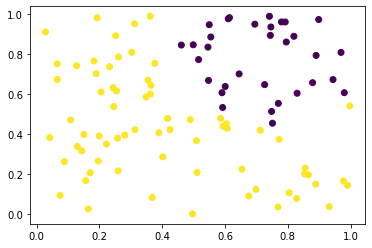

In [2]:
ndim = 2
npts = 100

x = np.random.random((ndim, npts))
y = np.ones(npts)

# mark some of them as -1
y[np.where(((x-0.75)**2).sum(axis=0)<0.1)] = -1

plt.scatter(x[0], x[1], c=y)

# Define objective function and constraints if needed

In [40]:
nplane = 2 # number of hyperplanes to use. nplane=1 is basically SVM

def elu(x):
    return jnp.where(x>0, x, jnp.exp(x)-1)

def fun(w):
    w = w.reshape((nplane, ndim+1))
    b = w[:,-1]
    A = w[:,:-1]
    res = A@x - b[:,None]
    mask = jnp.all((res<0), axis=0) # where all Ax<b 
    dist = jnp.min(abs(res), axis=0) # rough idea is to penalize distance to boundary
    err = (1-mask)*y*dist - mask*y*dist

    return jnp.sum(elu(-err))

# constraint to force A to have unit norm columns
def con(w):
    w = w.reshape((nplane, ndim+1))
    b = w[:,-1]
    A = w[:,:-1]
    norm = jnp.linalg.norm(A, axis=1)
    return 1-norm

# some JAX tools. As long as the original function is written using jax (ie jnp) you can get gradients/hessians/jacobians easily
# These are functions with the same signature as the original function, is call grad(x) to compute gradient
grad = jax.grad(fun)
hess = jax.hessian(fun)
conjac = jax.jacfwd(con)

# initial guess
A0 = 0.5-np.random.random((nplane*(ndim+1)))

# loss value at initial guess
fun(A0)

DeviceArray(-9.806493, dtype=float32)

# Optimize (local optimization seems not so good, could also be an issue with loss function)

In [41]:
import scipy.optimize

out = scipy.optimize.minimize(fun, 
                              x0=A0.flatten(), 
                              jac=grad, 
                              hess=hess, 
                              method="trust-constr", 
                              constraints=scipy.optimize.NonlinearConstraint(con, 0, 0, conjac),
                             )

/home/fouriest/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [42]:
out

         cg_niter: 23
     cg_stop_cond: 2
           constr: [array([ 0.0000000e+00, -1.1920929e-07], dtype=float32)]
      constr_nfev: [16]
      constr_nhev: [0]
      constr_njev: [16]
   constr_penalty: 18.625481647054052
 constr_violation: 1.1920928955078125e-07
   execution_time: 1.7210159301757812
              fun: DeviceArray(-26.146355, dtype=float32)
             grad: array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  8.9426537e+00,
        1.0349184e+01, -1.0641217e-03], dtype=float32)
              jac: [array([[0.26519242, 0.96419555, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.6538038 , 0.75666416,
        0.        ]], dtype=float32)]
  lagrangian_grad: array([ 0.        ,  0.        ,  0.        ,  0.00018776, -0.00016412,
       -0.00106412], dtype=float32)
          message: '`xtol` termination condition is satisfied.'
           method: 'equality_constrained_sqp'
             nfev: 16
             nh

In [43]:
# extract A, b
w = out['x'].reshape((nplane, ndim+1))
b = w[:,-1]
A = w[:,:-1]

# Plot results

boundaries are given by

$a_1 x_1 + a_2 x_2 = b$

ie, 

$x_2 = b/a_2 - a_1/a_2 x_1$

Plot below will show dividing lines in solid, and shade the region where $a x < b$ for each plane


(-2.0, 2.0)

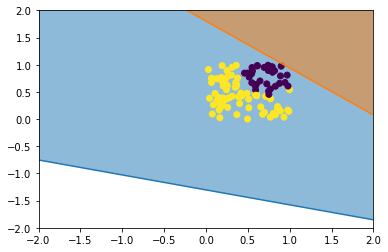

In [44]:
xmin = -2
xmax = 2
x1 = np.linspace(xmin,xmax,1000)
xx1, xx2 = np.meshgrid(x1,x1)

for i in range(nplane):
    a = A[i]
    bb = b[i]
    x2 = bb/a[1] - a[0]/a[1]*x1
    plt.plot(x1,x2)
    if a[1] > 0:
        plt.fill_between(x1,x2,-5, alpha=0.5)
    else:
        plt.fill_between(x1,x2,5, alpha=0.5)

plt.scatter(x[0], x[1], c=y)
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
